In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.model_selection import train_test_split
import seaborn as sns
from pandas.plotting import lag_plot
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from pmdarima import acf
from math import sqrt
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs

In [2]:
df = pd.read_csv('C:/Users/norri/Desktop/amazon_full.csv', parse_dates=['week'])
df = df[df['client_name'] == 'KIND']
df = df.drop_duplicates(subset=['sales', 'week'])
df['week'] = df['week'] = pd.to_datetime(df['week'])
df = df.sort_values(by=['week'])
df['sales'] = df['sales'].values
df = df.drop(columns=['brand_name', 'campaign_type', 'client_name'])

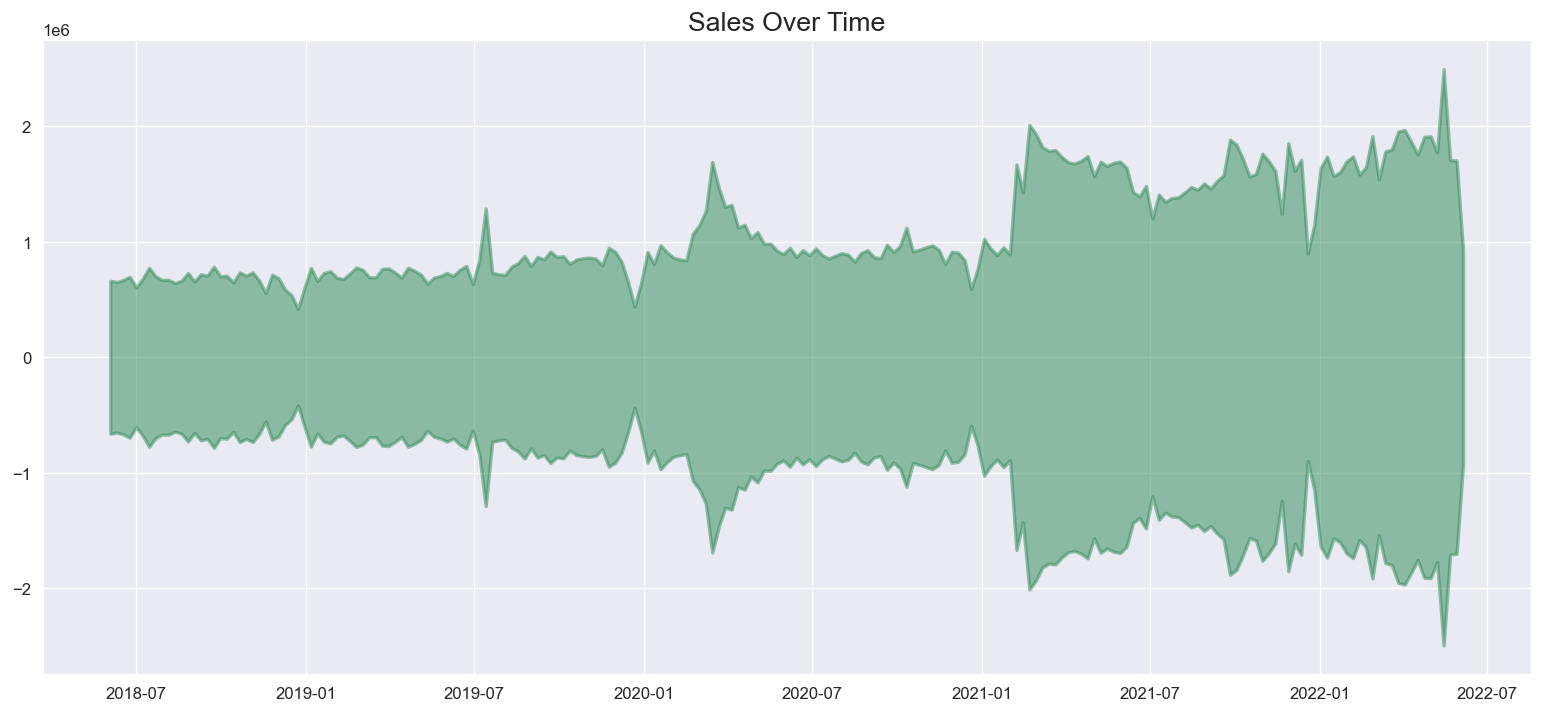

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(16,7), dpi= 120)
plt.fill_between(df['week'], y1=df['sales'], y2=-df['sales'], alpha=0.5, linewidth=2, color='seagreen')
plt.title('Sales Over Time', fontsize=16)
plt.show()

Explain the plot above and below

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Sales', dpi=100):
    plt.figure(figsize=(13, 13), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

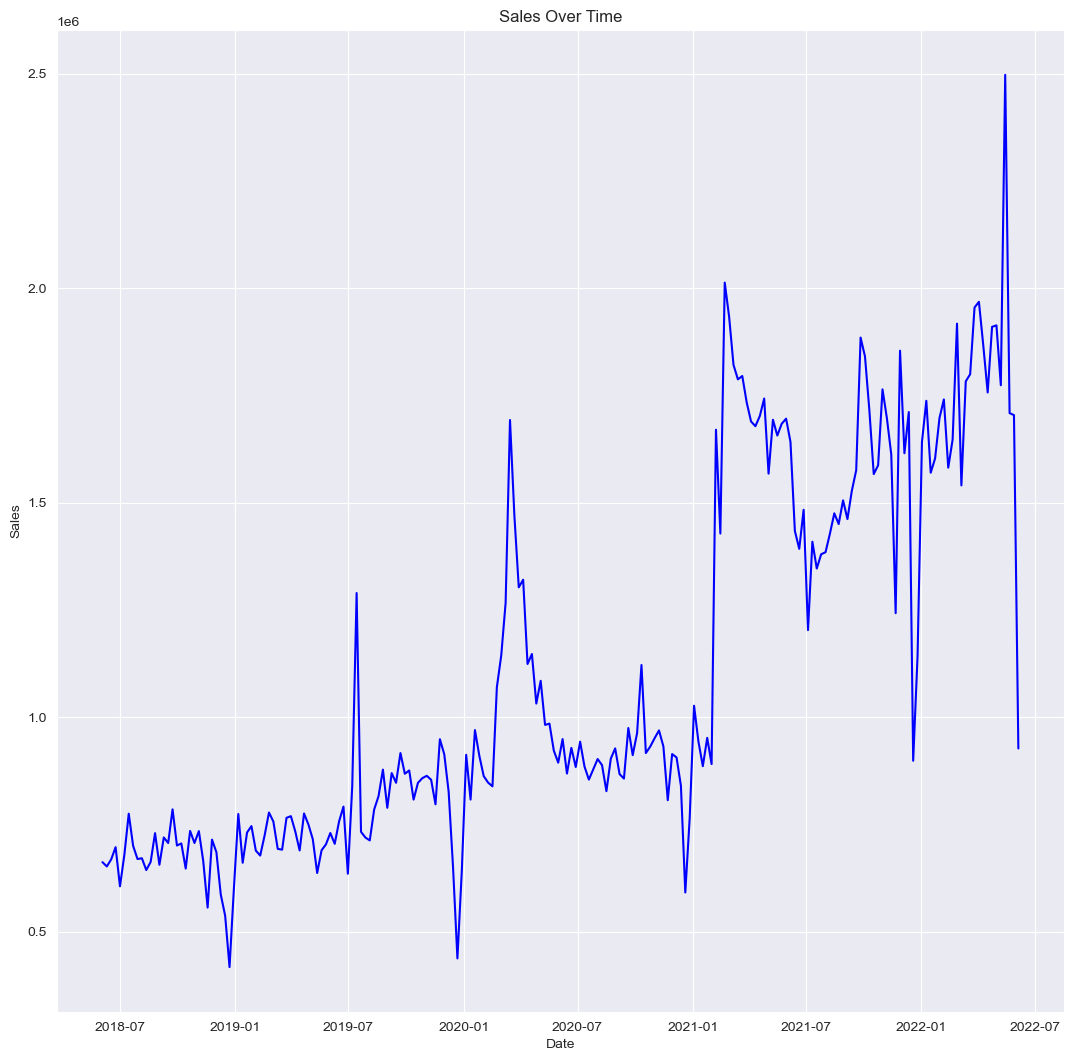

In [5]:
plot_df(df, df['week'], df['sales'], title='Sales Over Time')

Both plots appear to demonstrate a slight degree of annual cycles

Value = Base Level + Trend + Seasonality + Error - Additive Decomposition
Value = Base Level x Trend x Seasonality x Error - Multiplicative Decompisition

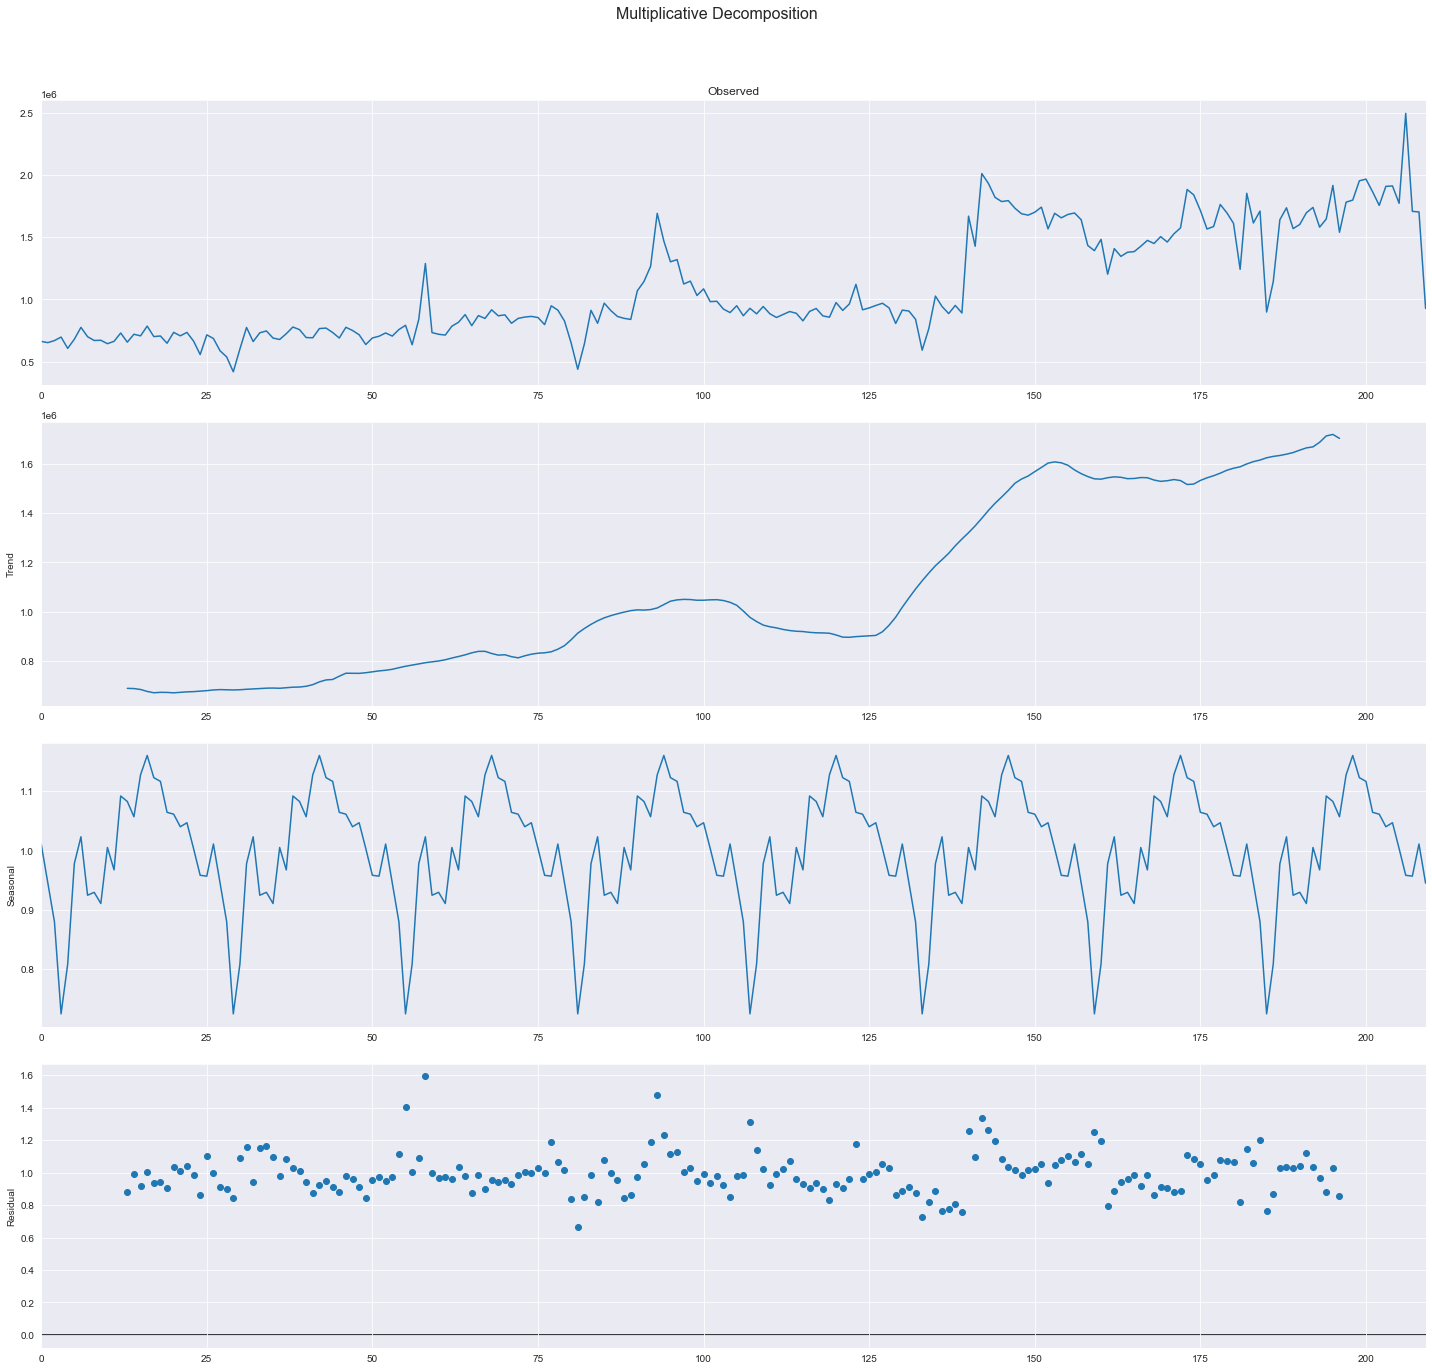

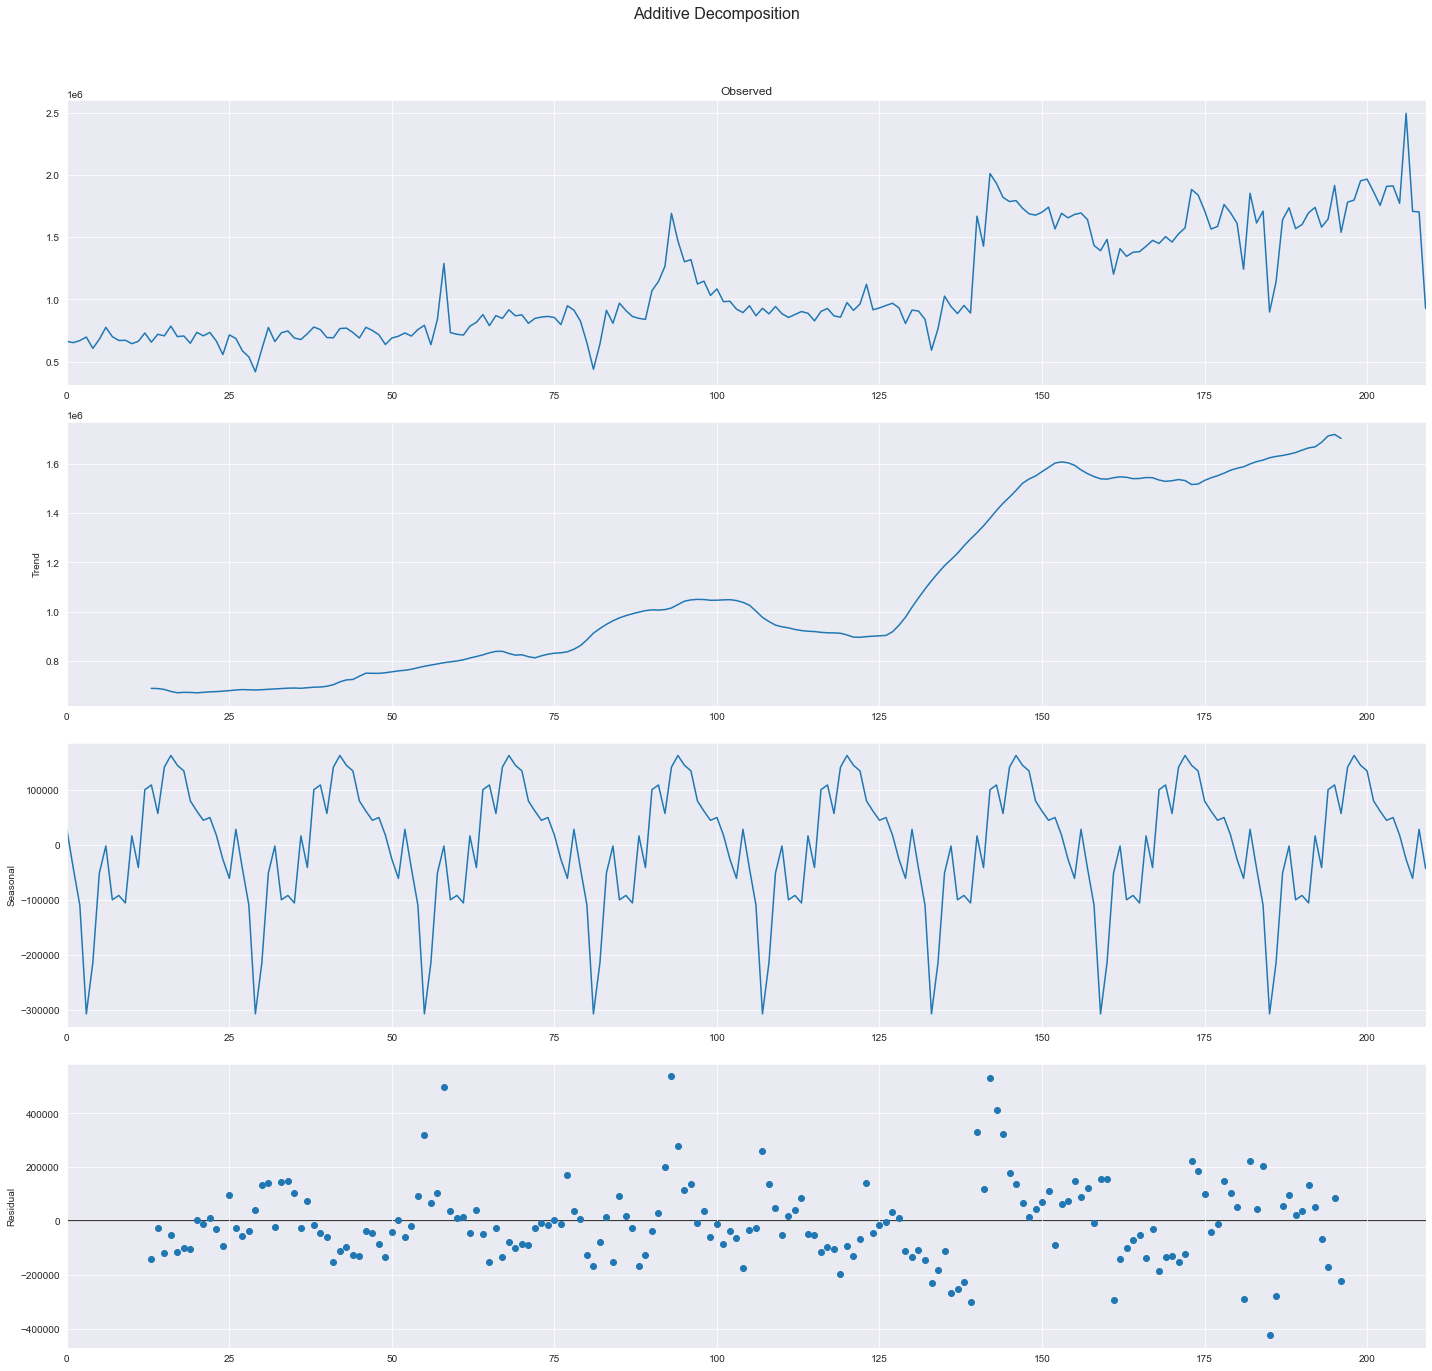

In [6]:
multiplicative_decomposition = seasonal_decompose(df['sales'].values,
                                                  model='multiplicative',
                                                  period=26)
additive_decomposition = seasonal_decompose(df['sales'].values, model='additive',
                                            period=26)
plt.rcParams.update({'figure.figsize': (20,20)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Variance of Residuals appear to be random and similar between additive and multiplicative

Explain interpretation of plots above and below

Text(0.5, 1.0, 'Sales Detrended')

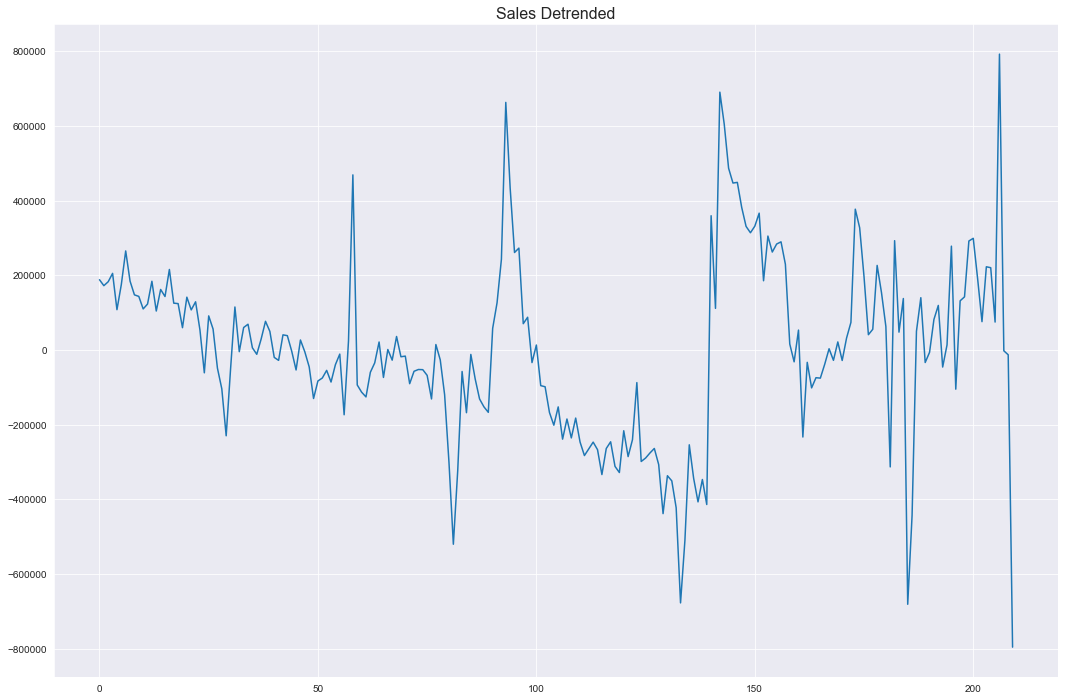

In [7]:
detrended = signal.detrend(df['sales'].values)
plt.rcParams.update({'figure.figsize': (18,12)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

[]

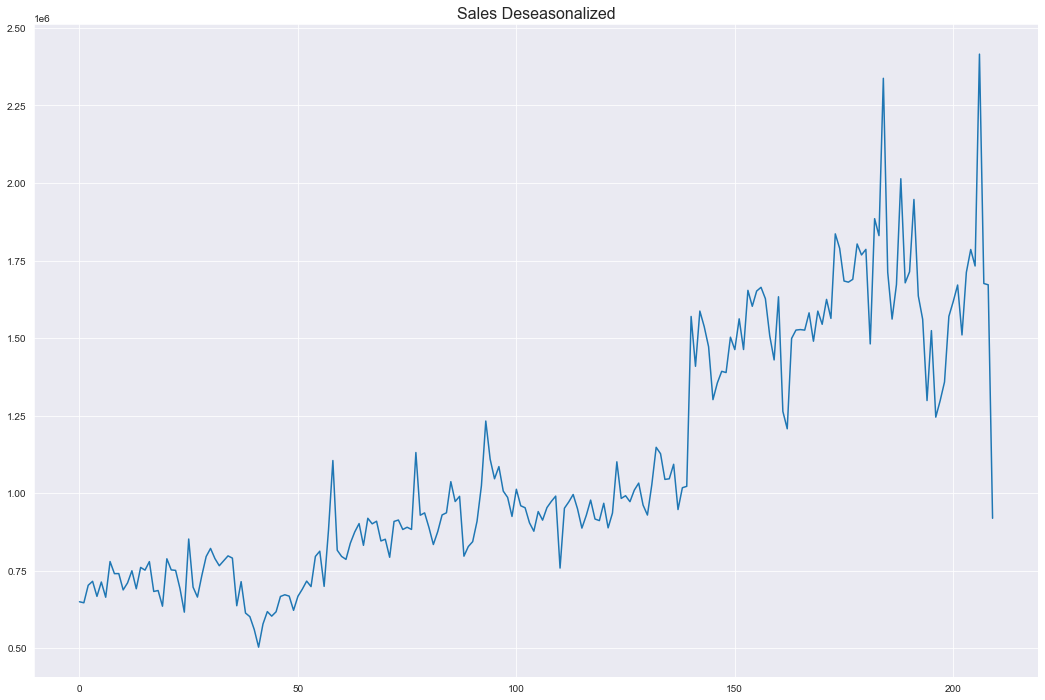

In [8]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=52)
deseasonalized = df['sales'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Sales Deseasonalized', fontsize=16)
plt.plot()

Elaborate on multiplicative, etc

Detrending and deasonalization show both a nonconstant variance and seasonality

Text(0.5, 1.0, 'Sales detrended')

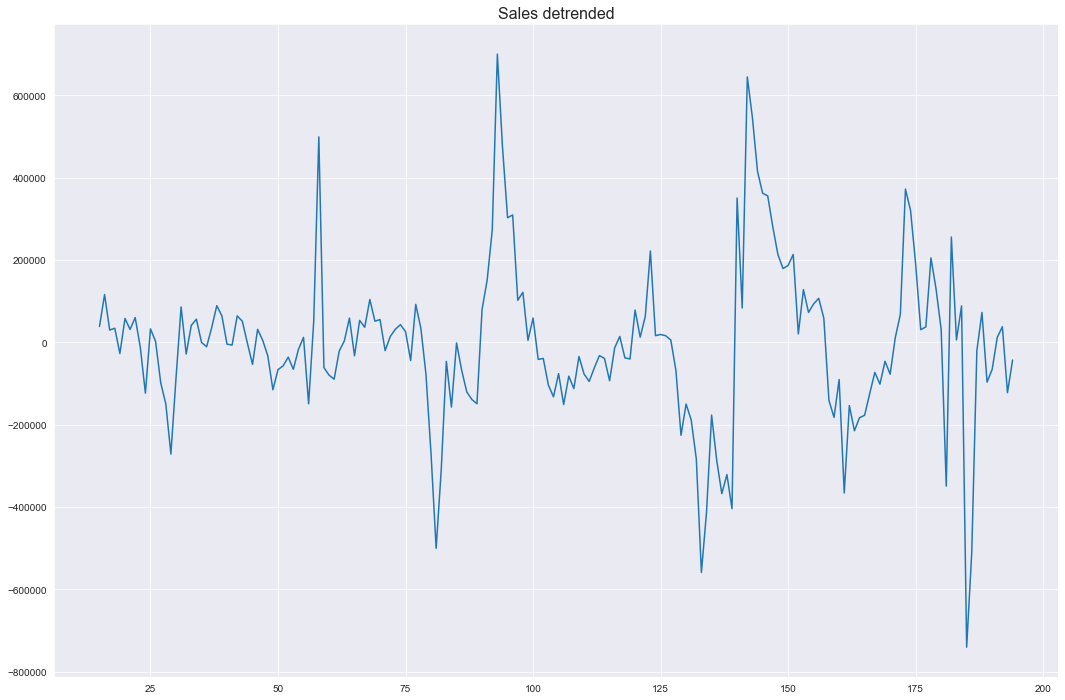

In [9]:
result_mul = seasonal_decompose(df['sales'].values, model='multiplicative', period=30)
detrended = df['sales'].values - result_mul.trend
plt.plot(detrended)
plt.title('Sales detrended', fontsize=16)

Explain detrending

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

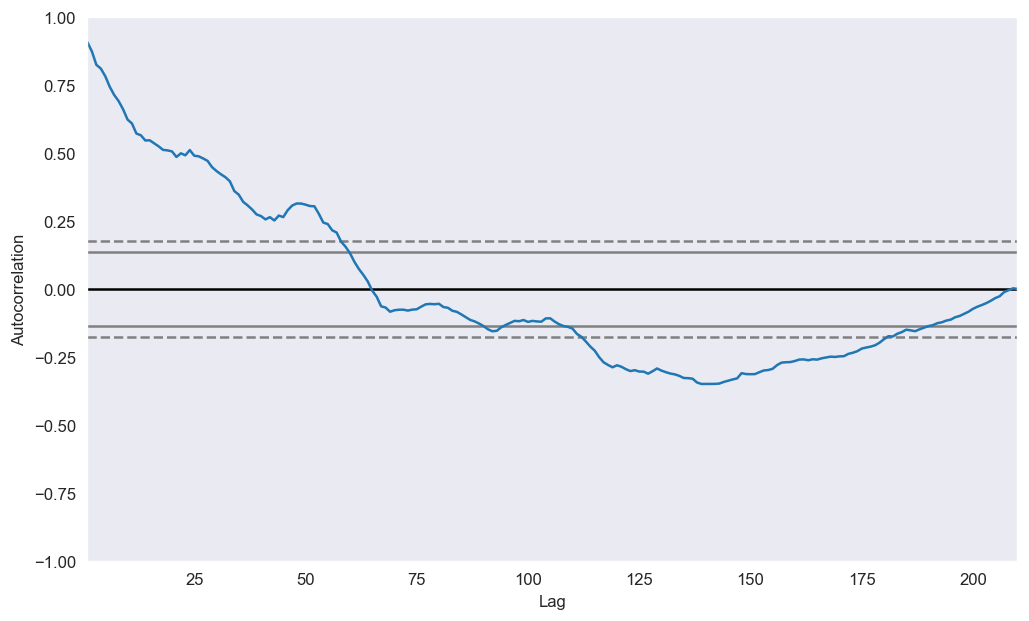

In [10]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(df['sales'].tolist())

Discuss autorcorrelatiomn

C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


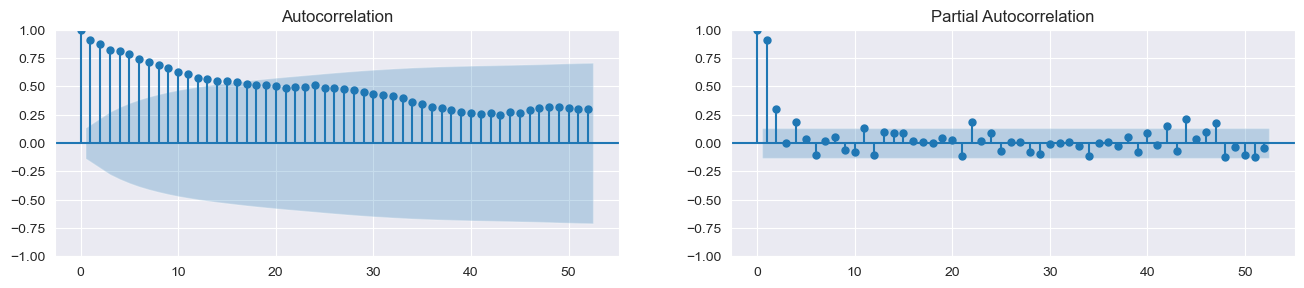

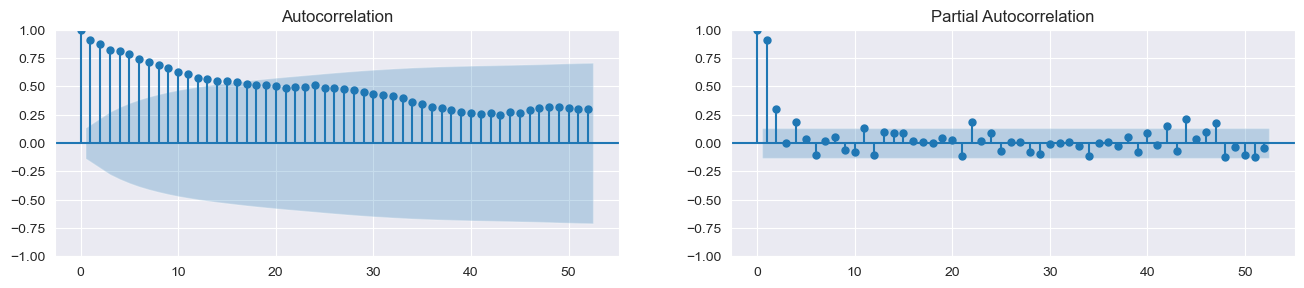

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)
plot_acf(df['sales'].tolist(), lags=52, ax=axes[0])
plot_pacf(df['sales'].tolist(), lags=52, ax=axes[1])

Discuss meaning of all four plots

Similar annual seasonality trends appear with peaks and valleys
on weekly basis

Point out what lag is and what it means for the model and what acceotable autolag
numbers are

In [12]:
ac1 = df['sales'].autocorr(lag=1)
print("One week Lag: ", ac1)
ac2 = df['sales'].autocorr(lag=2)
print("Two week Lag: ", ac2)
ac3 = df['sales'].autocorr(lag=3)
print("Three week Lag: ", ac3)
ac4 = df['sales'].autocorr(lag=4)
print("Four Week Lag: ", ac4)
ac5 = df['sales'].autocorr(lag=5)
print("Five Week Lag: ", ac5)
ac6 = df['sales'].autocorr(lag=6)
print("Six Week Lag: ", ac6)
ac7 = df['sales'].autocorr(lag=7)
print("seven Week Lag: ", ac7)
ac8 = df['sales'].autocorr(lag=8)
print("Eight Week Lag: ", ac8)
ac9 = df['sales'].autocorr(lag=9)
print("Nine Week Lag: ", ac9)
ac10 = df['sales'].autocorr(lag=10)
print("Ten Week Lag: ", ac10)
ac11 = df['sales'].autocorr(lag=11)
print("Eleven Week Lag: ", ac11)
ac12 = df['sales'].autocorr(lag=12)
print("Twelve Week Lag: ", ac12)

One week Lag:  0.9098153102364003
Two week Lag:  0.8821806039294661
Three week Lag:  0.8389246955797052
Four Week Lag:  0.8490497092696655
Five Week Lag:  0.8279749295809783
Six Week Lag:  0.7972397702030303
seven Week Lag:  0.7741044310663454
Eight Week Lag:  0.7569161243131861
Nine Week Lag:  0.7337078457624796
Ten Week Lag:  0.7031688420379568
Eleven Week Lag:  0.6983477370843819
Twelve Week Lag:  0.6648409440726896


Demonstration of small autocorrelation with lag

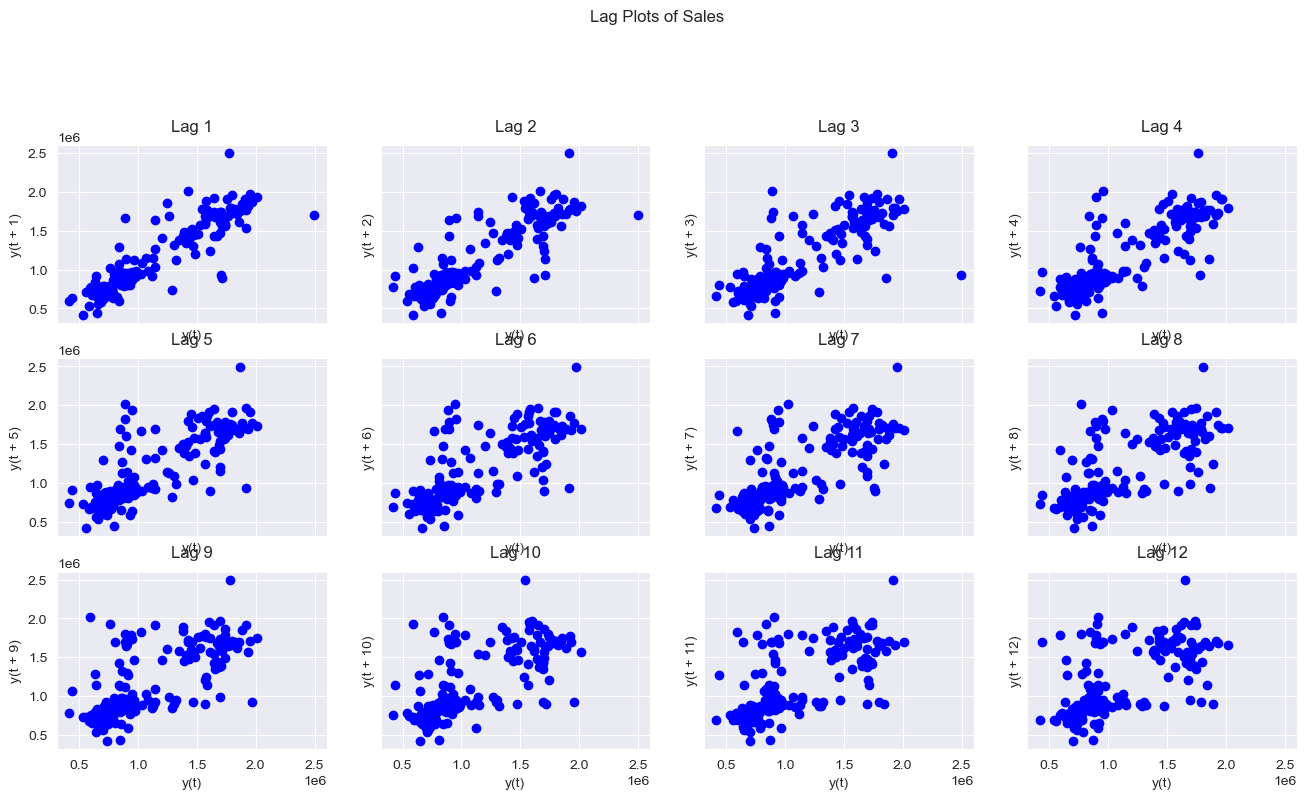

In [13]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(3, 4, figsize=(16, 8), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:12]):
    lag_plot(df['sales'], lag=i+1, ax=ax, c='blue')
    ax.set_title('Lag ' + str(i+1))
fig.suptitle('Lag Plots of Sales', y=1.05)
plt.show()

Decreasing linear trend between lag plots demonstrates similar results to
lag scores, suggesting some positive autocorrelation between first week

Check for better ARIMA measures

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df['week'], df['sales'],
                                                    test_size=0.33,
                                                    random_state=42)
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(y_train)
forecast = model.predict(n_periods=len(y_test))
forecast = pd.DataFrame(forecast,index = y_test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4030.918, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4030.398, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4031.259, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4030.581, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4309.057, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4031.085, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.592 seconds


SARIMAX GENERATOR

C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.396e+12   2.45e+11      5.705      0.000    9.16e+11    1.88e+12


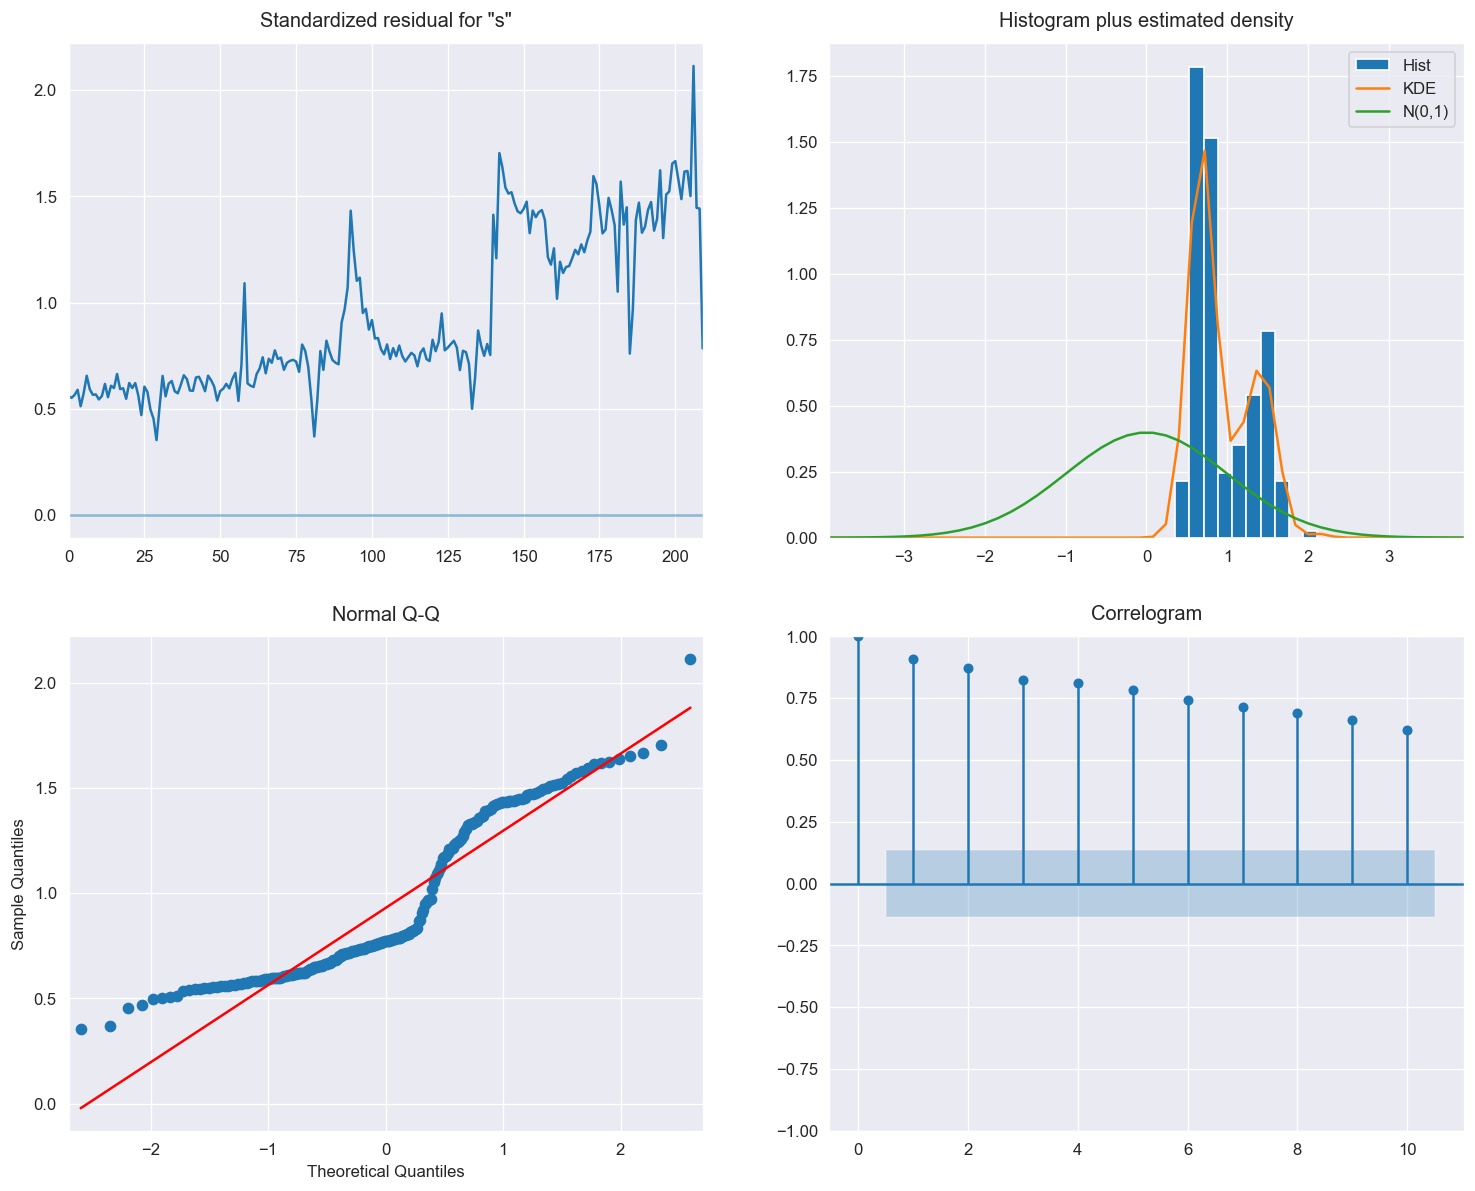

In [15]:
mod = sm.tsa.statespace.SARIMAX(df['sales'],
                                order=(0, 0, 0),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Bimodal distribution of residuals suggests model error is not fully corrected
for in ARIMA estimates

In [16]:
df_small = df[['week', 'sales']]

In [17]:
result = adfuller(df_small.sales.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.760572
p-value: 0.400205


DISCUSS HOW THESE NUMBERS CAN BE TOLERATED, AND ALSO WHAT DIFFERENCING IS

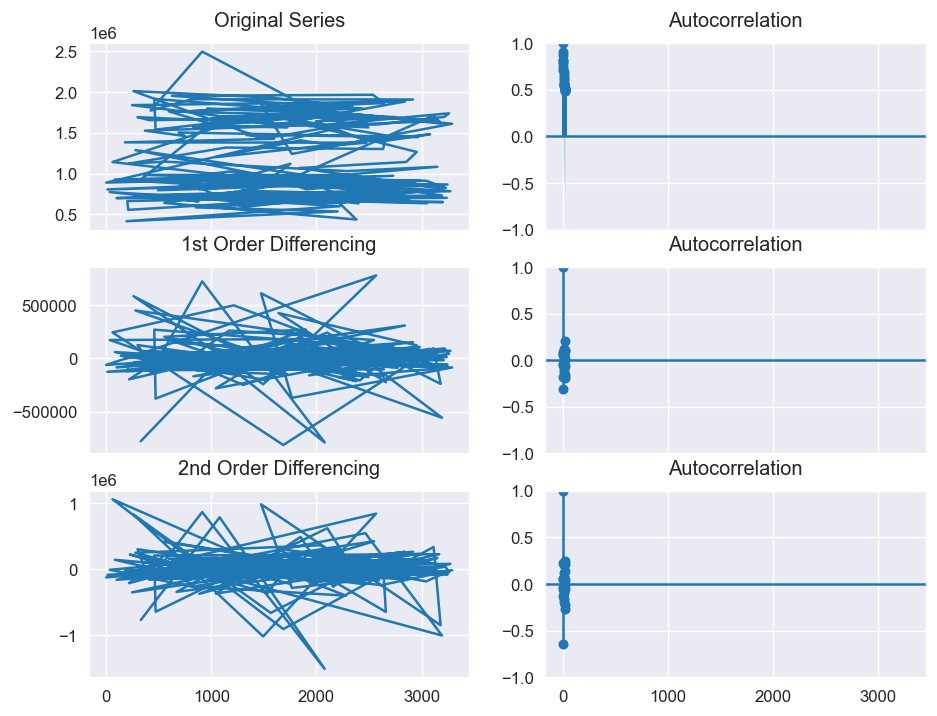

In [18]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_small.sales); axes[0, 0].set_title('Original Series')
plot_acf(df_small.sales, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_small.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_small.sales.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_small.sales.diff().diff()); axes[2, 0].set_title('2nd Order '
                                                                  'Differencing')
plot_acf(df_small.sales.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Point out what these number mean

In [19]:
y = df_small.sales
print(ndiffs(y, test='adf'))  # Adf Test
print(ndiffs(y, test='kpss'))  # KPSS test
print(ndiffs(y, test='pp')) # PP test

0
1
0


C:\Users\norri\.conda\envs\mercury-ds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


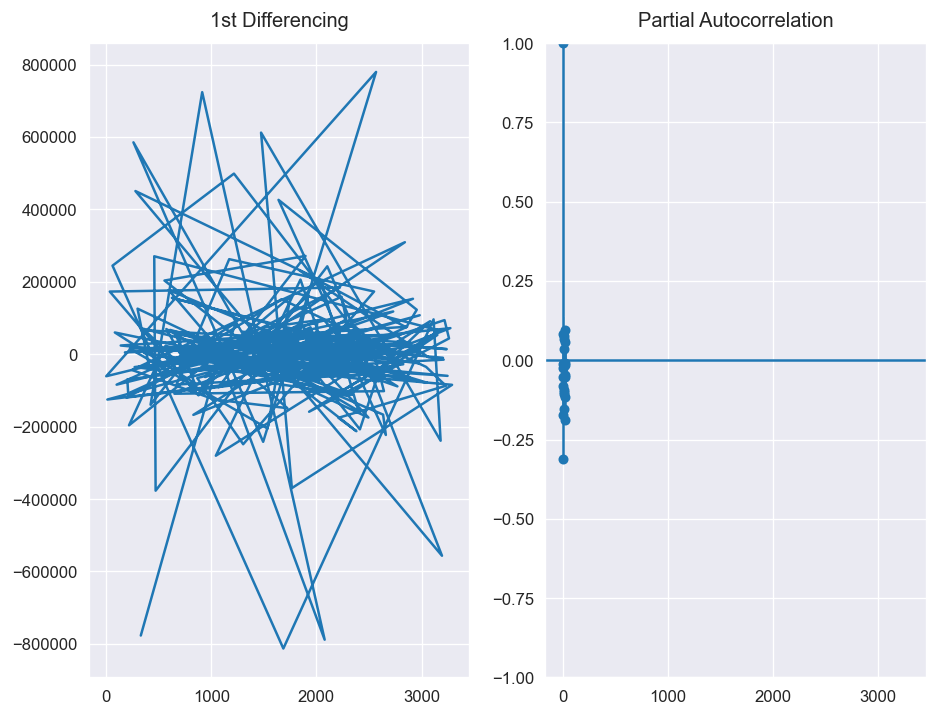

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['sales'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['sales'].diff().dropna(), ax=axes[1])
plt.show()

ensure that both plots are right and interpret them

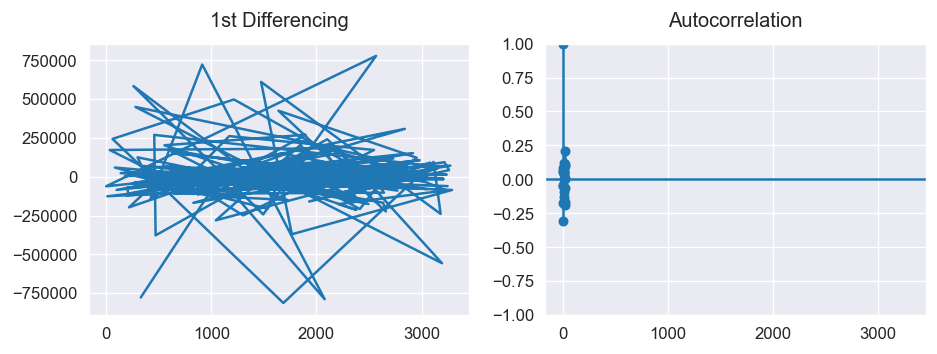

In [21]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_small['sales'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['sales'].diff().dropna(), ax=axes[1])
plt.show()

In [22]:
# Create Training and Test
df_small = df = df_small.sort_values(by=['week'])
df_small = df_small.reset_index()
df_small = df_small[['week', 'sales']]
train = df_small['sales'][:105]
test = df_small['sales'][105:]

See what these parameters do

In [23]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2735.958, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2735.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2734.359, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2733.997, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2731.299, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2733.092, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2733.220, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2732.727, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2733.998, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2730.136, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2732.487, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2733.508, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2731.985, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [24]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  560440.7134131071


Defome RMSE

In [27]:
model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit(method='statespace')
print(fitted.summary())
# Forecast
fc, se, conf = fitted.forecast(3, alpha=0.05)  # 95% conf
# # Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)
# # Plot
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
# plt.plot(test, label='actual')
# plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  105
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1359.069
Date:                Fri, 15 Jul 2022   AIC                           2728.138
Time:                        22:57:29   BIC                           2741.311
Sample:                             0   HQIC                          2733.473
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0754      0.082     -0.917      0.359      -0.237       0.086
ar.L2         -0.1777      0.120     -1.482      0.138      -0.413       0.057
ar.L3          0.0081      0.105      0.078      0.9

In [28]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc_series, test.values)

C:\Users\norri\AppData\Local\Temp\ipykernel_6636\2286732780.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\norri\AppData\Local\Temp\ipykernel_6636\2286732780.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],


{'mape': 0.30685369122433587,
 'me': -478939.4396030987,
 'mae': 501466.71884757344,
 'mpe': -0.27688954382877257,
 'rmse': 626267.2958845795,
 'acf1': 0.8258735929020937,
 'corr': 2.500334077705878e-16,
 'minmax': 0.3041846221689821}

Fix plot of prediced values

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2735.958, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2735.427, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2734.359, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2733.997, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2731.299, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2733.092, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2733.220, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2732.727, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2733.998, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2730.136, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2732.487, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2733.508, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2731.985, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

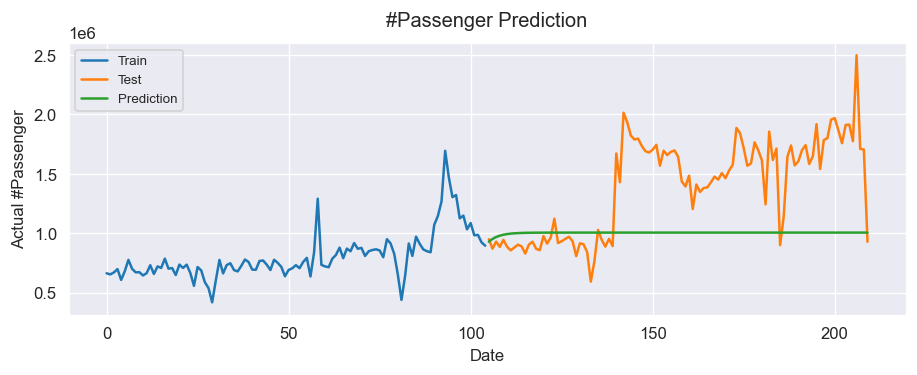

In [29]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('#Passenger Prediction')
plt.xlabel('Date')
plt.ylabel('Actual #Passenger')
plt.legend(loc='upper left', fontsize=8)
plt.show()